In [ ]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      # Instalar rdkit
      !pip -q install rdkit.pypi --upgrade
      pbar.update(20)
      # Instalar Pillow
      !pip -q install Pillow
      pbar.update(40)
      # Instalar molplotly
      !pip install molplotly --upgrade
      pbar.update(60)
      # Instalar jupyter-dash
      !pip install jupyter-dash
      pbar.update(80)
      # Instalar el diseño de aplicación dash
      !pip install dash-bootstrap-components
      pbar.update(100)

import io
from plotly import io as pio
import plotly.express as px
import molplotly
import dash_bootstrap_components as dbc
from sys import argv
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

  0%|          | 0/100 [00:00<?, ?it/s]


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

In [ ]:
!pip install -U kaleido

In [ ]:
data = pd.read_csv('/content/dbs_curated_SIDAS_DIANAT.csv')
data.head(3)

,Unnamed: 0,ID,SMILES,DATASET,curated_smiles
0,276,DiaNatDB-1,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1,DiaNat-DB,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1
1,277,DiaNatDB-10,O[C@H]1CC[C@@]2(C)[C@](CC[C@]3(C)[C@]2([H])CC[...,DiaNat-DB,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...
2,278,DiaNatDB-100,C[C@H](CCC(=C)C(C)C)[C@H]1CC[C@@]2([C@@]1(CC[C...,DiaNat-DB,C=C(CC[C@@H](C)[C@H]1CC[C@@]2(C)C3CC[C@H]4C(C)...


In [ ]:
data = data[['ID','DATASET','curated_smiles']]

In [ ]:
data

,ID,DATASET,curated_smiles
0,DiaNatDB-1,DiaNat-DB,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1
1,DiaNatDB-10,DiaNat-DB,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...
2,DiaNatDB-100,DiaNat-DB,C=C(CC[C@@H](C)[C@H]1CC[C@@]2(C)C3CC[C@H]4C(C)...
3,DiaNatDB-101,DiaNat-DB,Cc1ccc2c(c1)C(=O)CCO2
4,DiaNatDB-102,DiaNat-DB,CC(=O)c1ccccc1
...,...,...,...
607,2371,SH-accumulated,C=C(C)C1CCC2(C(=O)O)CCC3(C)C(CCC4C5(C)CCC(O)C(...
608,10494,SH-accumulated,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@...
609,107876,SH-accumulated,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(OC1(c3ccc(O...
610,19844,SH-accumulated,COC(=O)c1ccc(O)c(OC)c1


In [ ]:
data.shape

(612, 3)

In [ ]:
# eliminar filas en las que la columna curated_smiles tenga errores o valores nulos

# Define a function to check if a SMILES string is valid
def is_valid_smiles(smiles):
  try:
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None
  except:
    return False

# Filter rows where 'curated_smiles' is not null and is a valid SMILES string
data = data[data['curated_smiles'].notna() & data['curated_smiles'].apply(is_valid_smiles)].copy()

# Display the shape of the filtered data
print(data.shape)

# Display the first few rows of the filtered data
data.head(3)

(612, 3)


,ID,DATASET,curated_smiles
0,DiaNatDB-1,DiaNat-DB,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1
1,DiaNatDB-10,DiaNat-DB,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...
2,DiaNatDB-100,DiaNat-DB,C=C(CC[C@@H](C)[C@H]1CC[C@@]2(C)C3CC[C@H]4C(C)...


In [ ]:
data

,ID,DATASET,curated_smiles
0,DiaNatDB-1,DiaNat-DB,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1
1,DiaNatDB-10,DiaNat-DB,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...
2,DiaNatDB-100,DiaNat-DB,C=C(CC[C@@H](C)[C@H]1CC[C@@]2(C)C3CC[C@H]4C(C)...
3,DiaNatDB-101,DiaNat-DB,Cc1ccc2c(c1)C(=O)CCO2
4,DiaNatDB-102,DiaNat-DB,CC(=O)c1ccccc1
...,...,...,...
607,2371,SH-accumulated,C=C(C)C1CCC2(C(=O)O)CCC3(C)C(CCC4C5(C)CCC(O)C(...
608,10494,SH-accumulated,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@...
609,107876,SH-accumulated,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(OC1(c3ccc(O...
610,19844,SH-accumulated,COC(=O)c1ccc(O)c(OC)c1


In [ ]:
# Cargar el archivo con la columna 'curated_smiles'
df = data

# Función para calcular los descriptores
def calcular_descriptores(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series([None]*8, index=[
            'HBD', 'HBA', 'MolWt', 'LogP', 'TPSA',
            'NumRotatableBonds', 'NumOxygens', 'NumNitrogens'
        ])
    return pd.Series([
        Descriptors.NumHDonors(mol),                    # HBD
        Descriptors.NumHAcceptors(mol),                 # HBA
        Descriptors.MolWt(mol),                         # Peso molecular
        Descriptors.MolLogP(mol),                       # logP
        Descriptors.TPSA(mol),                          # Área polar
        Descriptors.NumRotatableBonds(mol),             # Enlaces rotables
        sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 8),  # Oxígeno
        sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 7)   # Nitrógeno
    ], index=[
        'HBD', 'HBA', 'MolWt', 'LogP', 'TPSA',
        'NumRotatableBonds', 'NumOxygens', 'NumNitrogens'
    ])

# Aplicar la función
df_descriptores = df['curated_smiles'].apply(calcular_descriptores)

# Unir con el DataFrame original
df_final = pd.concat([df, df_descriptores], axis=1)

# Mostrar los primeros resultados
print(df_final.head())

# Guardar como nuevo archivo CSV
df_final.to_csv('moléculas_con_descriptores.csv', index=False)


             ID    DATASET                                     curated_smiles  \
0    DiaNatDB-1  DiaNat-DB             O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1   
1   DiaNatDB-10  DiaNat-DB  C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...   
2  DiaNatDB-100  DiaNat-DB  C=C(CC[C@@H](C)[C@H]1CC[C@@]2(C)C3CC[C@H]4C(C)...   
3  DiaNatDB-101  DiaNat-DB                              Cc1ccc2c(c1)C(=O)CCO2   
4  DiaNatDB-102  DiaNat-DB                                     CC(=O)c1ccccc1   

   HBD  HBA    MolWt     LogP   TPSA  NumRotatableBonds  NumOxygens  \
0  4.0  4.0  174.152 -1.51620  97.99                1.0         5.0   
1  1.0  1.0  426.729  8.02480  20.23                1.0         1.0   
2  1.0  1.0  440.756  8.41490  20.23                5.0         1.0   
3  0.0  2.0  162.188  1.96022  26.30                0.0         2.0   
4  0.0  1.0  120.151  1.88920  17.07                1.0         1.0   

   NumNitrogens  
0           0.0  
1           0.0  
2           0.0  
3           0.

In [ ]:
df_final.info()
print(df_final.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 612 non-null    object 
 1   DATASET            612 non-null    object 
 2   curated_smiles     612 non-null    object 
 3   HBD                612 non-null    float64
 4   HBA                612 non-null    float64
 5   MolWt              612 non-null    float64
 6   LogP               612 non-null    float64
 7   TPSA               612 non-null    float64
 8   NumRotatableBonds  612 non-null    float64
 9   NumOxygens         612 non-null    float64
 10  NumNitrogens       612 non-null    float64
dtypes: float64(8), object(3)
memory usage: 52.7+ KB
             ID    DATASET                                     curated_smiles  \
0    DiaNatDB-1  DiaNat-DB             O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1   
1   DiaNatDB-10  DiaNat-DB  C=C(C)[C@@H]1CC[C@]2(C)CC[C@

### Generar PCA

#### 1. Dividir base de datos

In [ ]:
#Dividir matriz
data = df_final.iloc[:,3:11].values # Seleccionar columnas con descriptores


In [ ]:
label = df_final.iloc[:,2].values # Seleccionar el nombre de la base de datos(label) de las columnas

In [ ]:
pd.DataFrame(data).head(5)

,0,1,2,3,4,5,6,7
0,4.0,4.0,174.152,-1.51620,97.99,1.0,5.0,0.0
1,1.0,1.0,426.729,8.02480,20.23,1.0,1.0,0.0
2,1.0,1.0,440.756,8.41490,20.23,5.0,1.0,0.0
3,0.0,2.0,162.188,1.96022,26.30,0.0,2.0,0.0
4,0.0,1.0,120.151,1.88920,17.07,1.0,1.0,0.0


#### 2. Normalizar datos
StandardScaler() estandariza las características del conjunto de datos en la escala de la unidad (media = 0 y varianza = 1) que es un requisito para el rendimiento óptimo de muchos algoritmos de aprendizaje automático.

In [ ]:
# Normalizar datos
from sklearn.preprocessing import StandardScaler
data_std = StandardScaler().fit_transform(data)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_results = pca.fit_transform(data_std)
pca_results

array([[-0.7265055 , -1.57455547, -0.75798266],
       [-2.36532887,  1.45359597, -0.42466658],
       [-2.18437616,  2.10632841, -0.09465382],
       ...,
       [ 3.18581688,  0.09072048, -0.14595177],
       [-1.59755968, -0.58751004, -0.64426543],
       [-0.97175354,  1.15594576, -0.26408955]])

In [ ]:
# Seleccionar imformación complementaria
label = df_final[["DATASET", "ID", "curated_smiles"]]
label = label.to_numpy()

In [ ]:
# Concatenar arrays de numpy
arr = np.concatenate((label, pca_results), axis = 1)
# Crear un nuevo dataframe
pca_dataset = pd.DataFrame(data=arr, columns = ['Dataset',"ID", "curated_smiles",'component1', 'component2', "component3"])
pca_dataset.head(2)

,Dataset,ID,curated_smiles,component1,component2,component3
0,DiaNat-DB,DiaNatDB-1,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1,-0.726505,-1.574555,-0.757983
1,DiaNat-DB,DiaNatDB-10,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...,-2.365329,1.453596,-0.424667


Al realizar el método de PCA, hay una pérdida de correlación con cada componente, por esto es necesario poder identificar la cantidad de correlación que poseemos para nuestras representaciones visuales, pudiendo determinar si estas serán relevantes o no por la cantidad de correlación que posean con la muestra original.

Finalmente, se pretende visualizar la varianza explicada por cada componente principal utilizando una gráfica de barras y una gráfica escalonada. La variable "cum_sum_eigenvalues" es un arreglo numpy que contiene la suma acumulativa de la varianza explicada por cada componente principal. Luego, se utiliza la función "plt.bar()" para crear la gráfica de barras de la varianza explicada para cada componente principal y la función "plt.step()" para crear la gráfica escalonada de la varianza explicada acumulada. Finalmente, se ajustan los ejes y se muestran ambas gráficas utilizando "plt.tight_layout()" y "plt.show()".

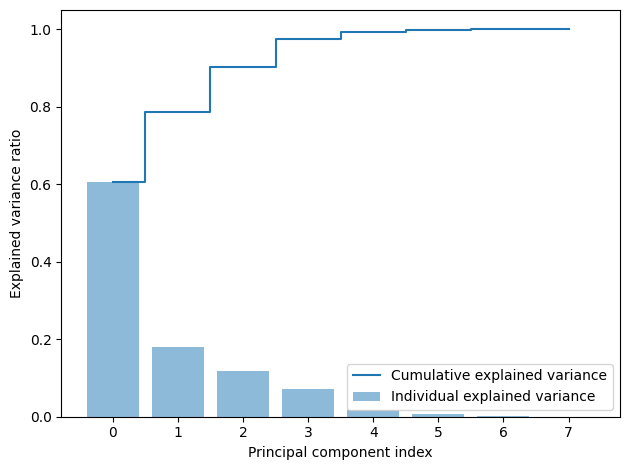

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(data)
X_train_std = sc.transform(data)
#X_test_std = sc.transform(X_test)
# Instantiate PCA
pca = PCA()

# Determine transformed features
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
import matplotlib.pyplot as plt
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
exp_var_pca[0]

np.float64(0.6057658591754682)

In [ ]:
pca_dataset.head(2)

,Dataset,ID,curated_smiles,component1,component2,component3
0,DiaNat-DB,DiaNatDB-1,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](O)C1,-0.726505,-1.574555,-0.757983
1,DiaNat-DB,DiaNatDB-10,C=C(C)[C@@H]1CC[C@]2(C)CC[C@]3(C)[C@H](CC[C@@H...,-2.365329,1.453596,-0.424667


Ahora vamos a usar **seaborn** para hacer el gráfico de PCA. En este gráfico, los puntos de datos similares deberían estar más cerca, formando clusters. Para este conjunto de datos nos gustaría ver a las distintas bases de datos, formando grupos distintos.
(Al hacer el gráfico de dispersión, el parámetro `DataBase` se corresponde con el color de los puntos).

In [ ]:
set(list(pca_dataset["Dataset"]))

{'DiaNat-DB', 'SG-accumulated', 'SH-accumulated', 'SR-accumulated'}

In [ ]:
# Varianza explicada por componente:

var_pc1 = exp_var_pca[0] * 100
var_pc2 = exp_var_pca[1] * 100
print(f"Varianza explicada por el primer componente principal: {var_pc1:.2f}%")
print(f"Varianza explicada por el segundo componente principal: {var_pc2:.2f}%")

Varianza explicada por el primer componente principal: 60.58%
Varianza explicada por el segundo componente principal: 18.04%


In [ ]:
#Graficar
import plotly.express as px
import molplotly
fig_pca = px.scatter(pca_dataset,
                            x='component1',
                            y='component2',
                            #symbol='Minimum Degree',
                            color='Dataset',
                            color_discrete_sequence=["#979745", "#4AB82B", "#304be3",
                                                     "#19a3a6"], #color code: Glabra #4ab82b, Hyssopi #19a3a6, Rhombi #304be3, Dianat: #979745

                            title=False,
                            labels={'PC1': 'PC_1',
                                    'PC2': 'PC_2'},
                            width=1000,
                            height=800)


# Aumentar tamaño de los puntos
fig_pca.update_traces(marker=dict(size=10))

fig_pca.update_layout(
    xaxis=dict(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True, tickfont=dict(size=14, color='black')),
    yaxis=dict(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True, tickfont=dict(size=14, color='black')),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=True  # Esta línea elimina la leyenda
)
000000


# Modify x-axis label
# Modify x-axis label
fig_pca.update_xaxes(
    title_text="Principal component 1 (60.58%)",
    range=[-5, 10],
    title_font=dict(size=20, color= "black")
)

fig_pca.update_yaxes(
    title_text="Principal component 2 (18.04%)",
    range=[-4, 8],
    title_font=dict(size=20, color= "black")
)

app_marker = molplotly.add_molecules(fig=fig_pca,
                                         df=pca_dataset,
                                         smiles_col='SMILES',
                                         title_col='ID',
                                         color_col='Dataset'
                                        )
pio.write_image(fig_pca, 'pca_plot_all_dbs.png', width=1000, height=800, scale=3)

#fig_pca.show()
#app_marker.run_server(mode='inline', port=8060, height=1000)
app_marker.run(port=8060)

/usr/local/lib/python3.11/dist-packages/dash/dash.py:587: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>

# Saving different datasets combinations from the PCA plot

In [ ]:
set(list(pca_dataset["Dataset"]))

{'DiaNat-DB', 'SG-accumulated', 'SH-accumulated', 'SR-accumulated'}

In [ ]:
selected_datasets = ['DiaNat-DB']  # Specify the datasets you want
filtered_data = pca_dataset[pca_dataset['Dataset'].isin(selected_datasets)]

In [ ]:
#Graficar
import kaleido
import plotly.express as px
import molplotly
import io
from plotly import io as pio

fig_pca = px.scatter(filtered_data,
                            x='component1',
                            y='component2',
                            #symbol='Minimum Degree',
                            color='Dataset',
                            color_discrete_sequence=["#979745"],
                     #color code: Glabra #4ab82b, Hyssopi #19a3a6, Rhombi #304be3, Dianat: #979745

                            title=False,
                            labels={'PC1': 'PC_1',
                                    'PC2': 'PC_2'},
                            width=1000,
                            height=800)

# Aumentar tamaño de los puntos
fig_pca.update_traces(marker=dict(size=15))

fig_pca.update_layout(
    xaxis=dict(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True, tickfont=dict(size=24, color='black')),
    yaxis=dict(showgrid=False, showline=True, linewidth=1, linecolor='black', mirror=True, tickfont=dict(size=24, color='black')),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False  # Esta línea elimina la leyenda
)
000000


# Modify x-axis label
# Modify x-axis label
fig_pca.update_xaxes(
    title_text="Principal component 1",
    range=[-5, 10],
    title_font=dict(size=30, color= "black")
)

fig_pca.update_yaxes(
    title_text="Principal component 2",
    range=[-4, 8],
    title_font=dict(size=30, color= "black")
)

app_marker = molplotly.add_molecules(fig=fig_pca,
                                         df=pca_dataset,
                                         smiles_col='SMILES',
                                         title_col='ID',
                                         color_col='Dataset'
                                        )
pio.write_image(fig_pca, 'pca_plot_dianat.png', width=1000, height=800, scale=3)

#fig_pca.show()
#app_marker.run_server(mode='inline', port=8060, height=1000)
app_marker.run(port=8060)

<IPython.core.display.Javascript object>